In [ ]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder


n =7 #Number of classes for segmentation
SIZE_Y=256
SIZE_X=256
#Upload original Images into a list
#Modify the extension in accordance with your specific data
images = []

for img_path in glob.glob("/content/drive/MyDrive/Patient__SEP/Patient-13/extract_brain/crop_image/*.png"):
        img = cv2.imread(img_path, 0)
        print(img_path)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        images.append(img)

#Convert list to array
images = np.array(images)

#Upload mask Images into a list

groundtruth = []
classes=[]
valeur_pixel=[]
for mask_path in glob.glob("DataSet_path_mask/*.tif"):
        mask = cv2.imread(mask_path, 0)
        print("Class values in image  "+mask_path , np.unique(mask))
        print(len (np.unique(mask)))
        classes.append(len (np.unique(mask)))
        valeur_pixel.append(np.unique(mask))# 0 is the background
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        groundtruth.append(mask)

groundtruth = np.array(groundtruth)


#convert categorical columns into numerical ones
labelencoder = LabelEncoder()
n, h, w = groundtruth.shape
groundtruth_resh = groundtruth.reshape(-1,1)
gt_reshaped_encoded = labelencoder.fit_transform(v)

#reshape data into original shape
gt_encoded_original_shape = gt_reshaped_encoded.reshape(n, h, w)


#Train images
images = np.expand_dims(images, axis=3)
images = normalize(images, axis=1)

train_masks_input = np.expand_dims(gt_encoded_original_shape, axis=3)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X, X_valid, y, y_valid = train_test_split(images, train_masks_input, test_size = 0.10, random_state = 0)

#keep data for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

train_masks_cat = to_categorical(y_train, num_classes=n)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n))



valid_masks_cat = to_categorical(y_valid, num_classes=n)
y_valid_cat = valid_masks_cat.reshape((y_valid.shape[0], y_valid.shape[1], y_valid.shape[2], n))

Class values in the dataset are ...  [0 1 2 3 4 5 6]


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import SGD , Adam

from tensorflow.keras import backend as K
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  return (1.0-dice_coef(y_true, y_pred))

def multiclasse_unet(n_classes=7, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1= BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1= BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2= BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2= BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3= BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3= BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4= BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4= BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5= BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5= BatchNormalization()(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6= BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6= BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7= BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7= BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8= BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8= BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9= BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9= BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',dice_coef,tf.keras.metrics.MeanIoU(num_classes=7),tf.keras.metrics.Recall()])
    model.summary()

    return model


In [ ]:
#Training

from sklearn.utils import class_weight

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


model = multiclasse_unet(n_classes=n, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)


history = model.fit(X_train, y_train_cat,
                    batch_size = 16,
                    verbose=1,
                    epochs=170,
                    validation_data=(X_valid, y_valid_cat),
                    #class_weight=class_weights,
                    shuffle=True)



model.save('test_segmentation.hdf5')

############################################################
#Evaluate the model

_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Mean IoU = 0.6412874


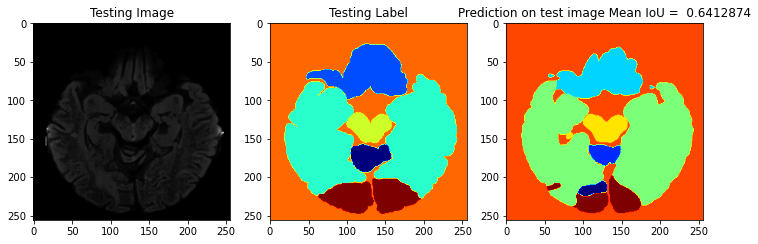

Mean IoU = 0.6954348


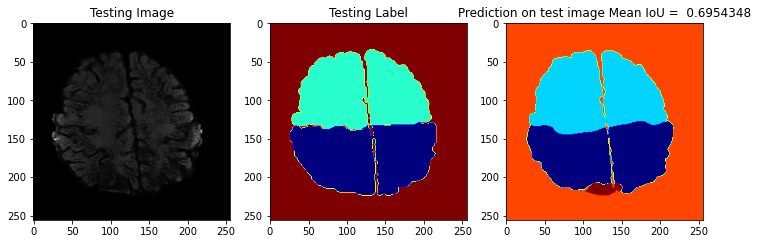

Mean IoU = 0.7146167


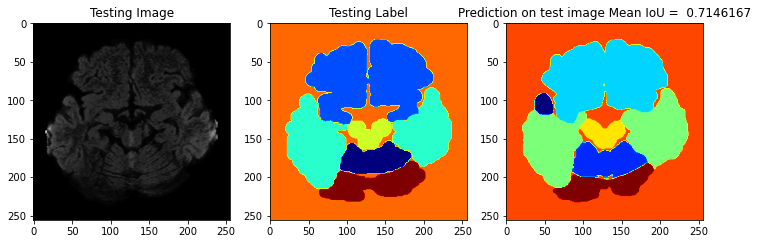

Mean IoU = 0.7916753


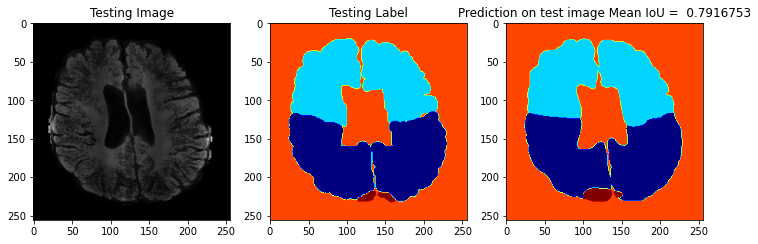

Mean IoU = 0.69954765


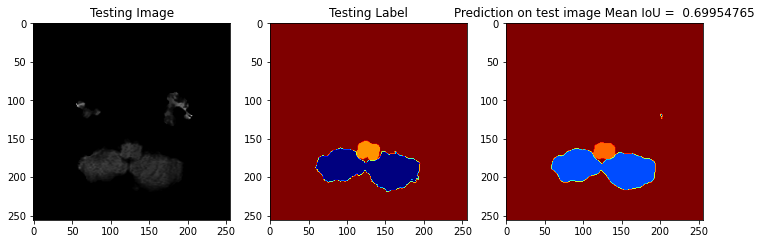

Mean IoU = 0.8642517


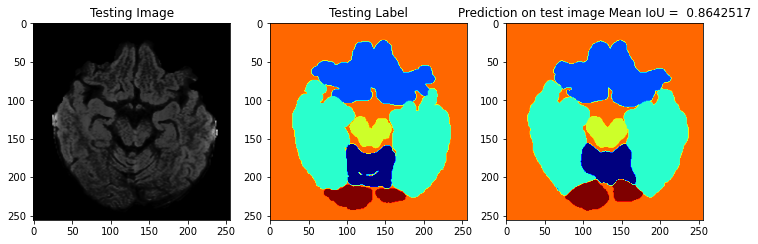

Mean IoU = 0.67704886


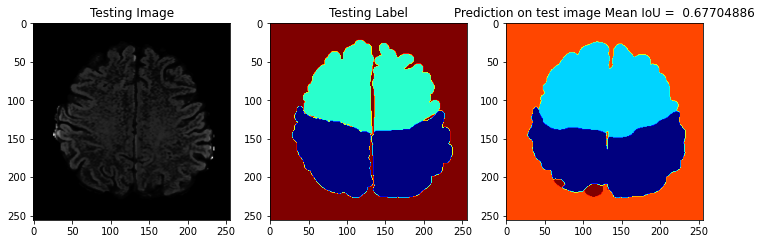

Mean IoU = 0.61996907


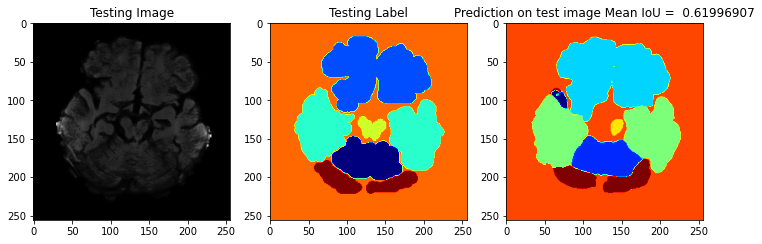

Mean IoU = 0.7597645


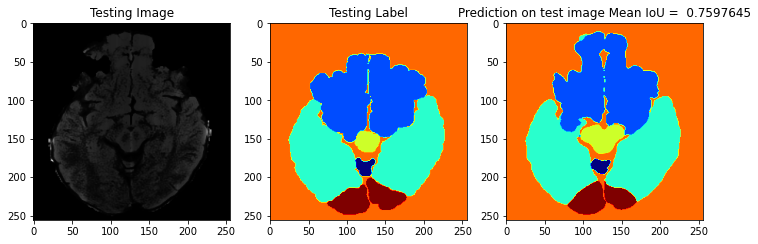

Mean IoU = 0.69839376


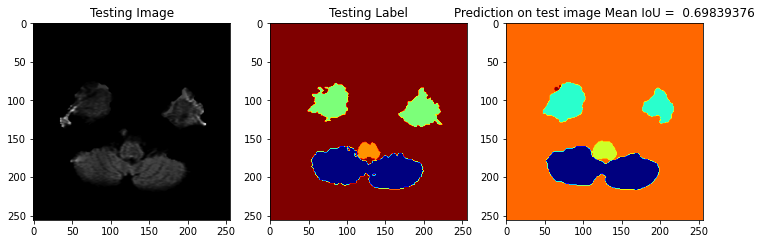

Mean IoU = 0.8019527


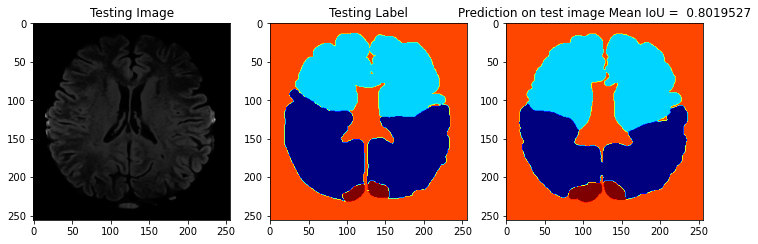

Mean IoU = 0.5928016


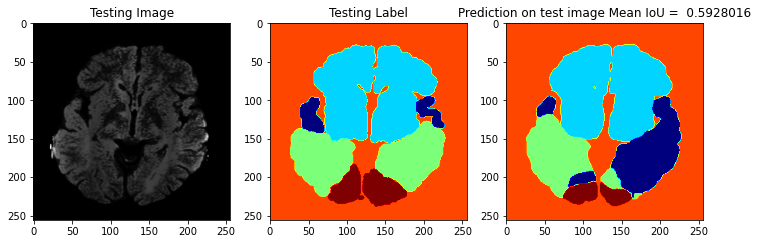

Mean IoU = 0.66275656


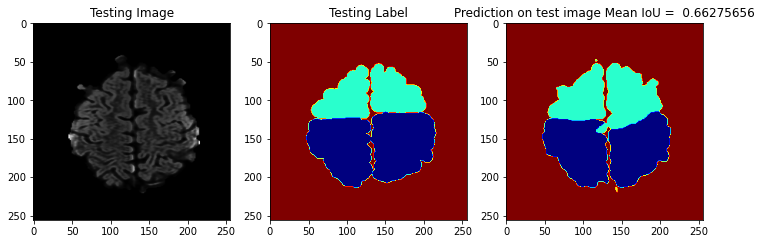

Mean IoU = 0.6611182


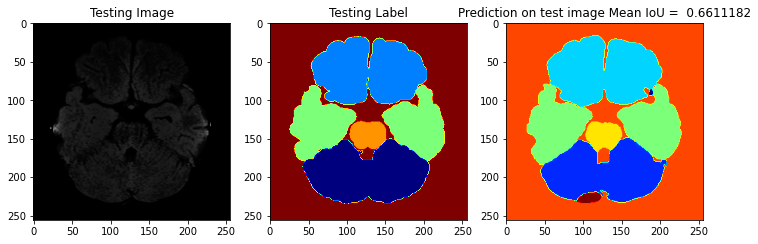

Mean IoU = 0.64128745


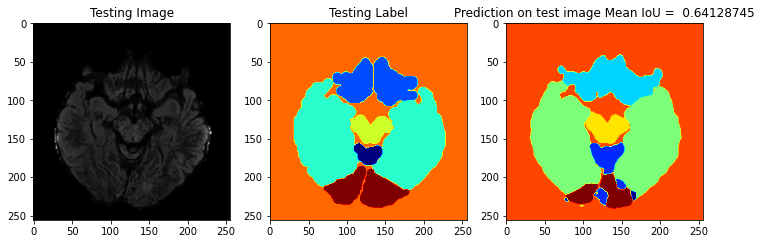

Mean IoU = 0.6581654


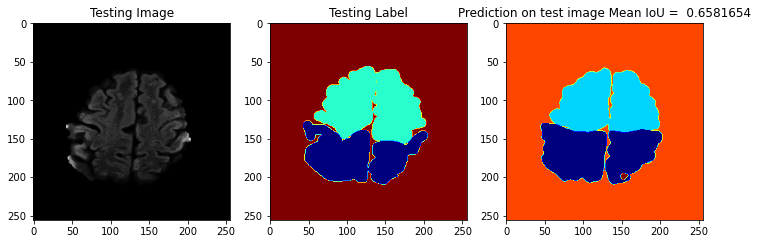

Mean IoU = 0.7733922


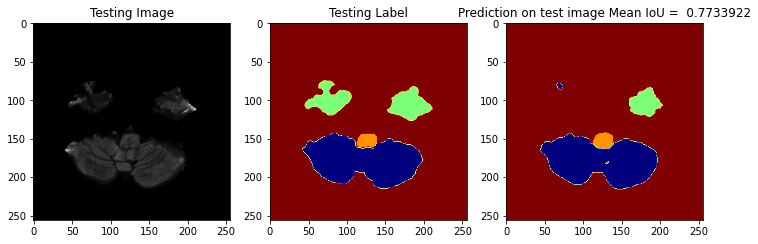

Mean IoU = 0.60772556


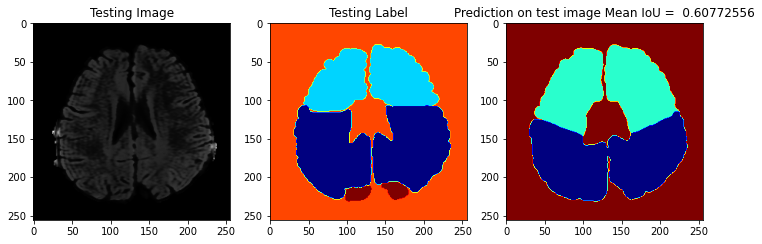

Mean IoU = 0.9201414


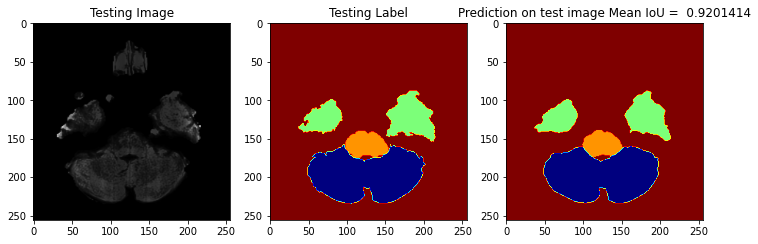

Mean IoU = 0.81265366


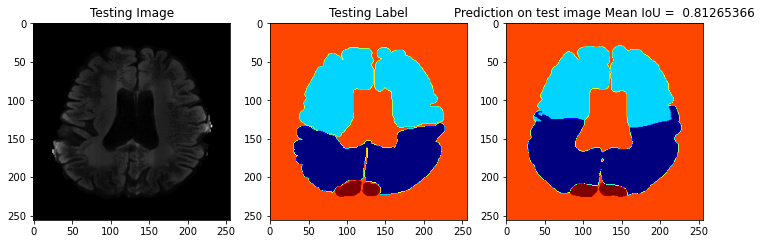

Mean IoU = 0.6474332


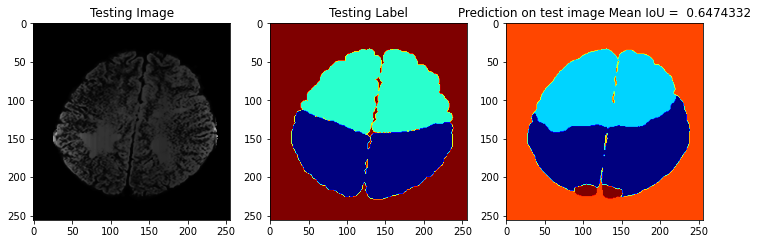

Mean IoU = 0.9194886


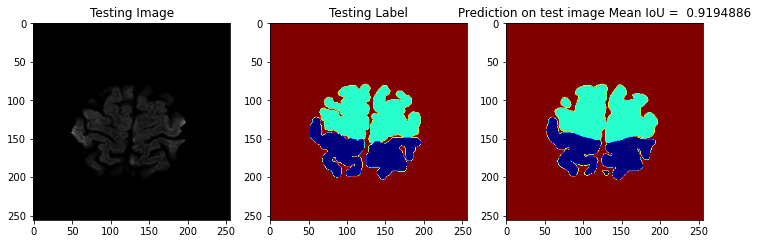

Mean IoU = 0.829277


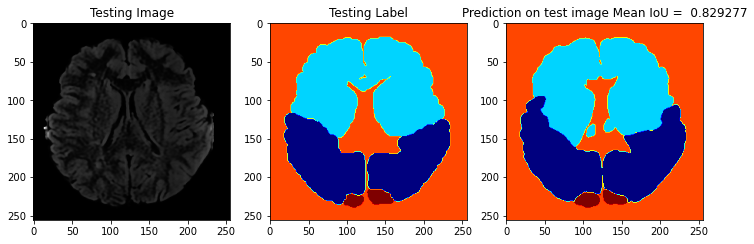

Mean IoU = 0.9326966


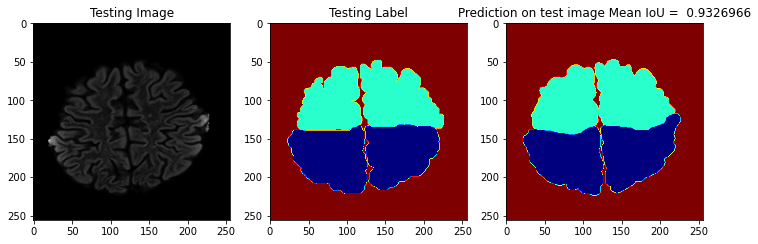

Mean IoU = 0.7749594


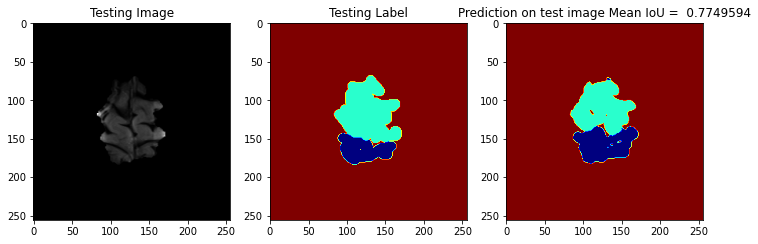

Mean IoU = 0.8592718


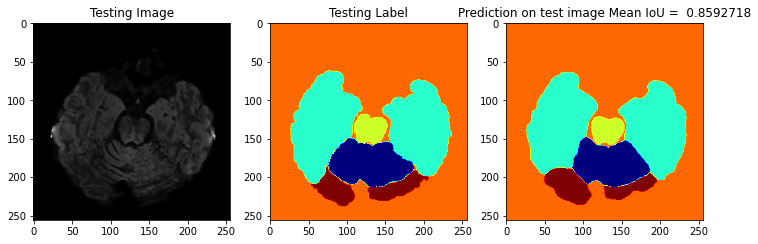

Mean IoU = 0.55177844


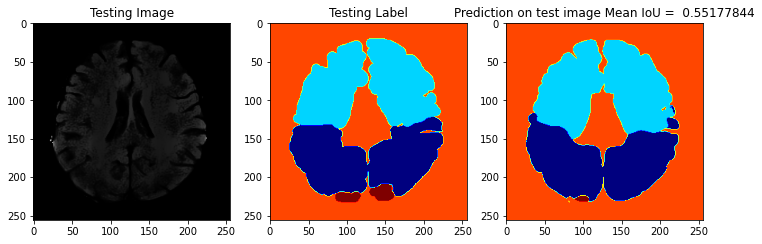

Mean IoU = 0.4272514


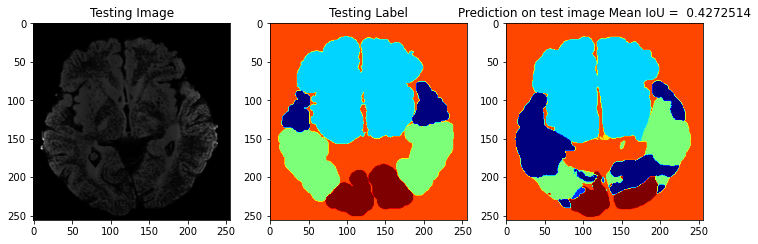

Mean IoU = 0.34816995


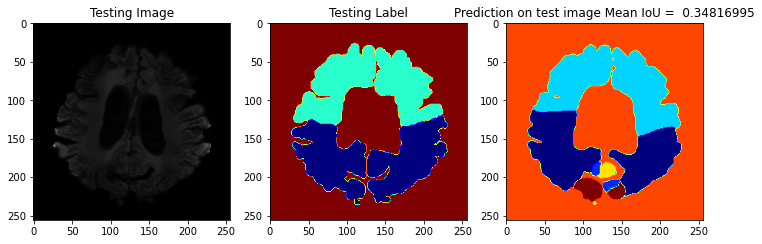

Mean IoU = 0.80272496


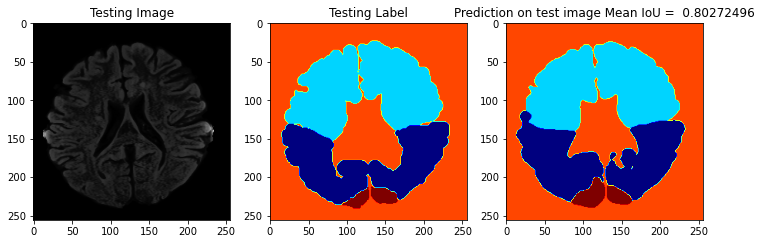

Mean IoU = 0.64742875


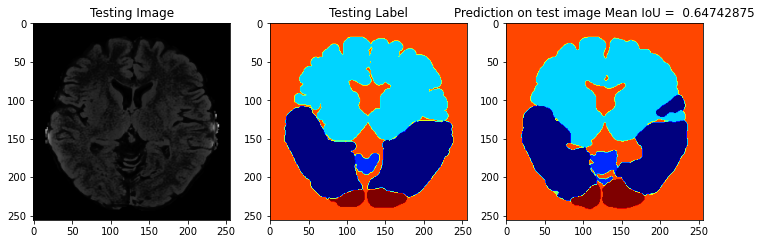

Mean IoU = 0.79415673


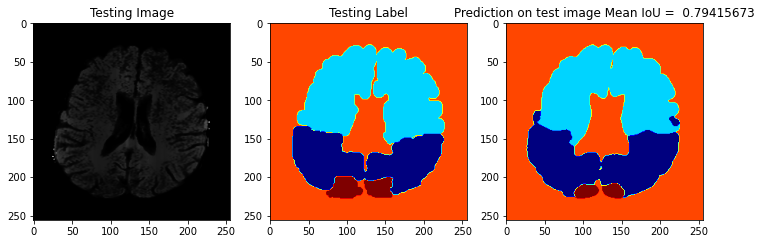

Mean IoU = 0.8381033


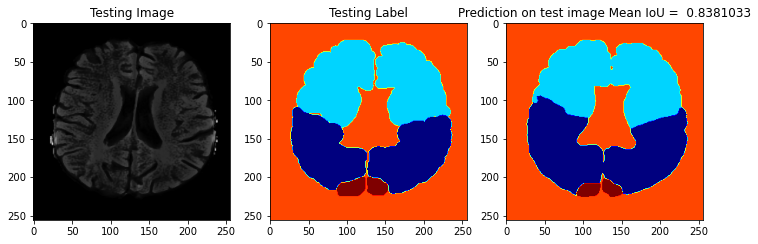

Mean IoU = 0.5942406


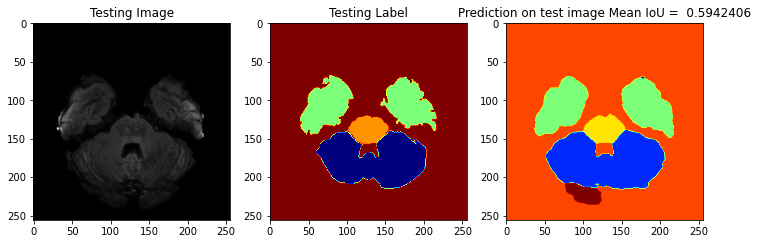

Mean IoU = 0.61527395


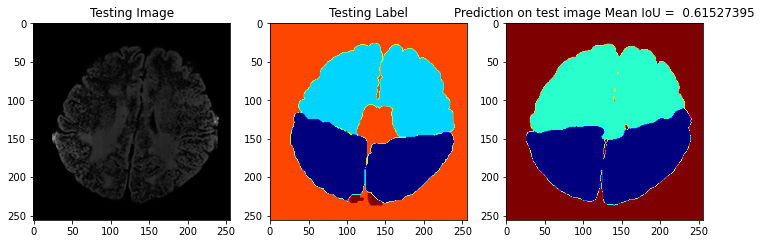

Mean IoU = 0.6711794


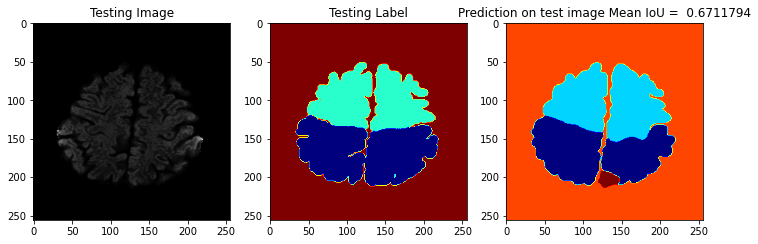

Mean IoU = 0.69408363


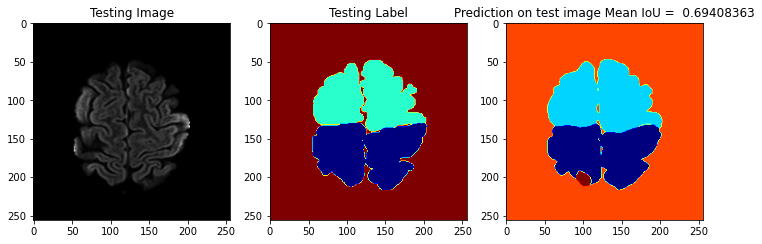

Mean IoU = 0.66824615


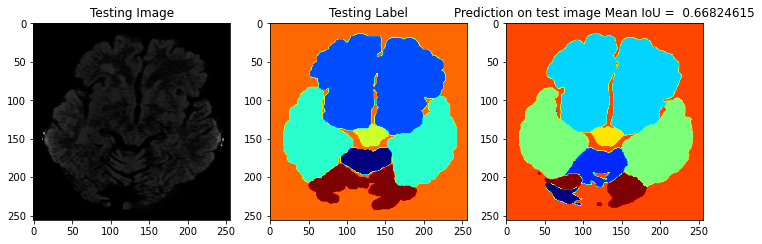

Mean IoU = 0.76097924


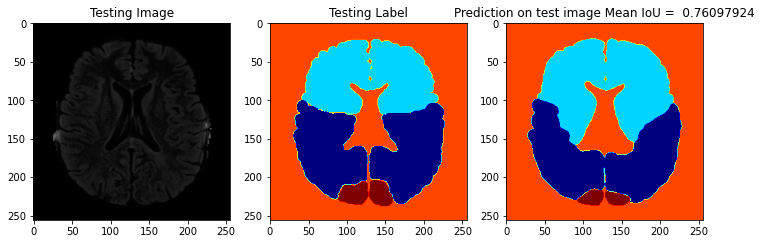

Mean IoU = 0.8582919


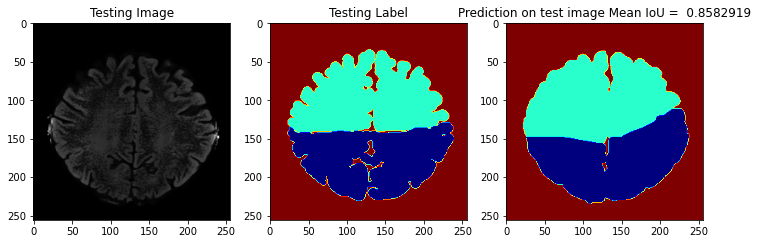

Mean IoU = 0.8157474


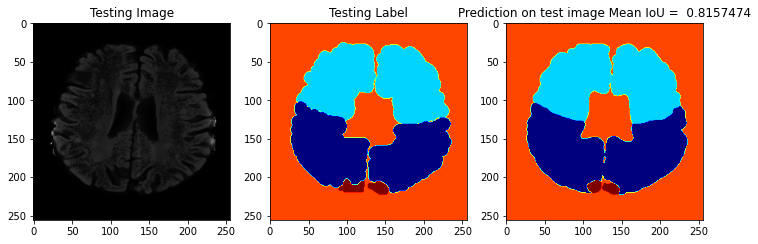

Mean IoU = 0.50370175


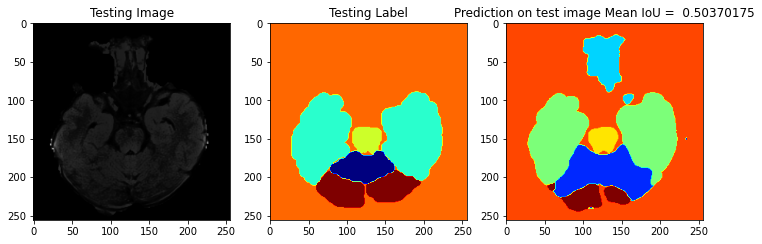

Mean IoU = 0.85998416


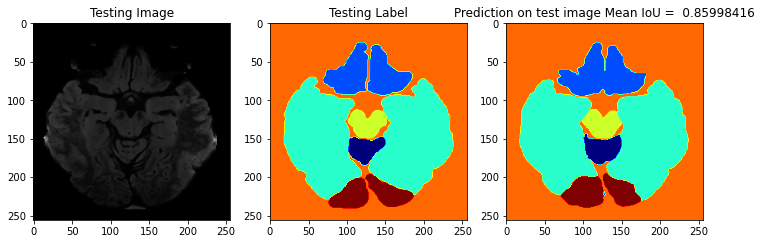

Mean IoU = 0.5182848


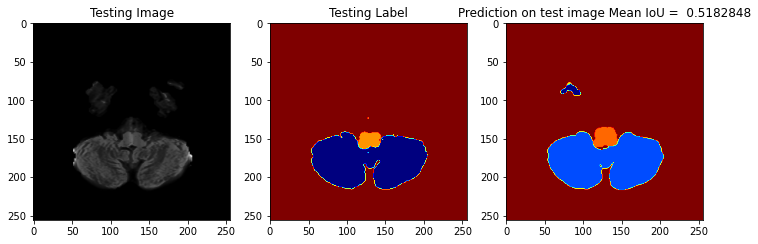

Mean IoU = 0.60668606


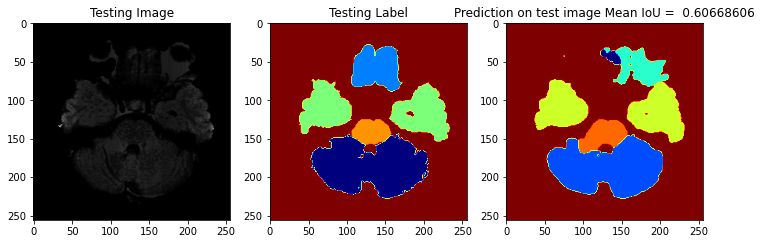

Mean IoU = 0.884177


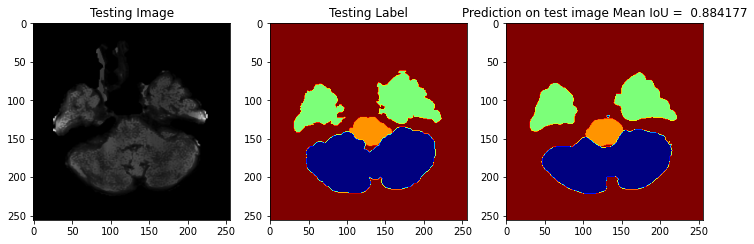

Mean IoU = 0.88795775


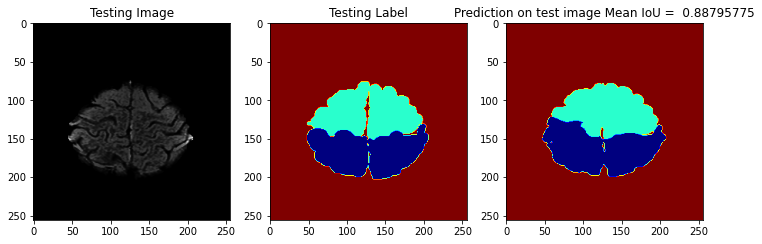

Mean IoU = 0.6945788


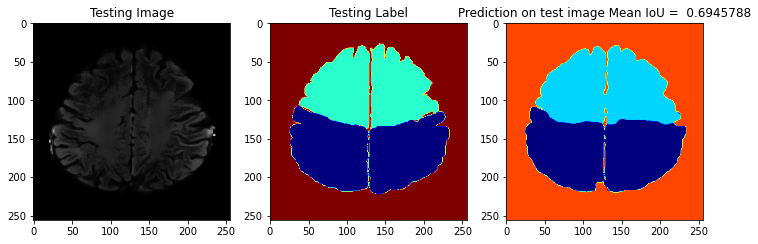

Mean IoU = 0.59142196


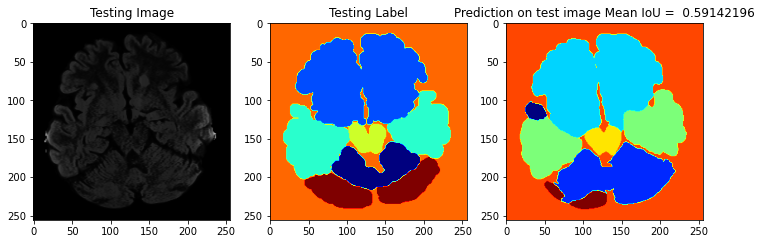

Mean IoU = 0.9530967


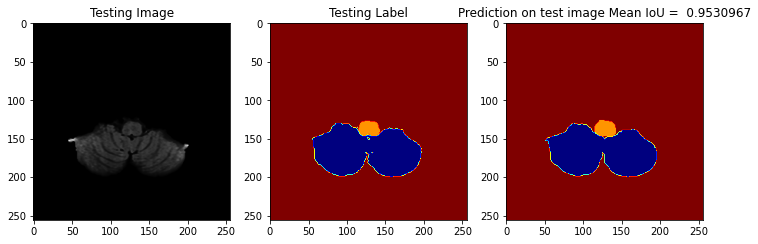

Mean IoU = 0.6782343


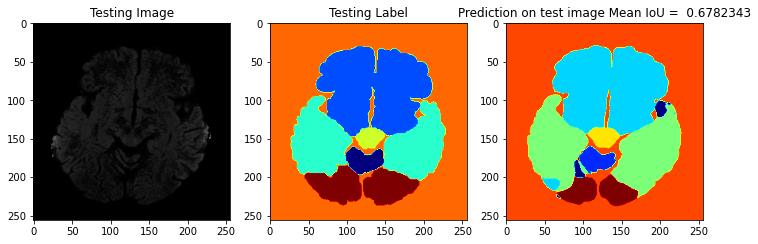

Mean IoU = 0.6815924


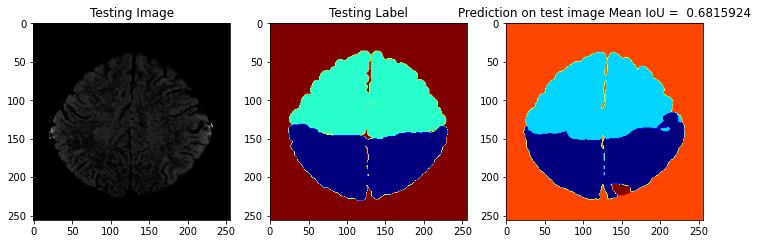

Mean IoU = 0.66012627


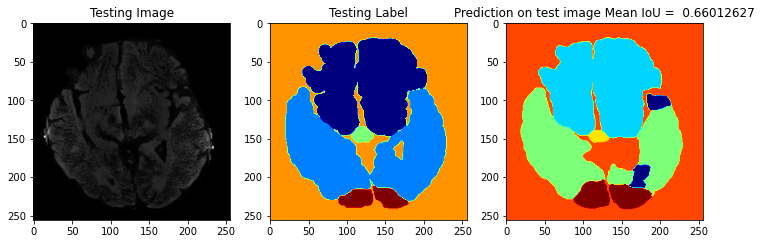

Mean IoU = 0.68858266


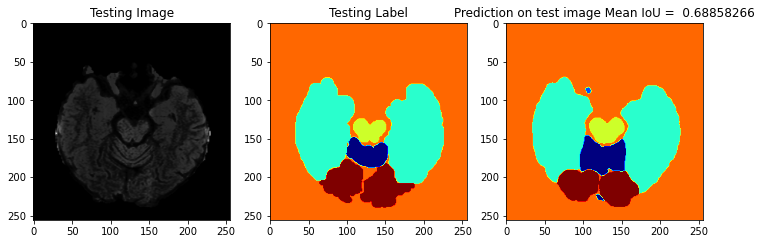

Mean IoU = 0.78059065


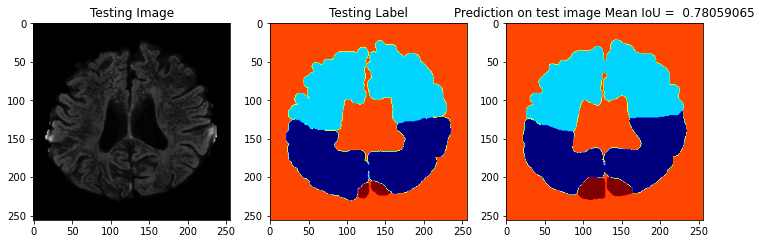

Mean IoU = 0.6886548


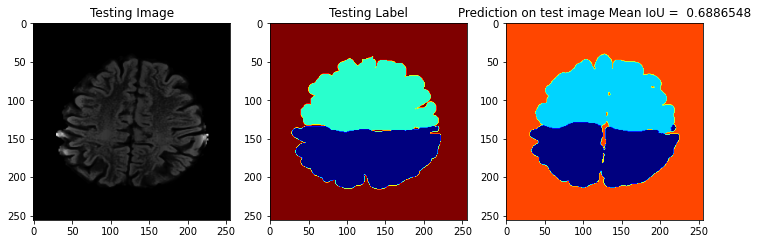

Mean IoU = 0.8059302


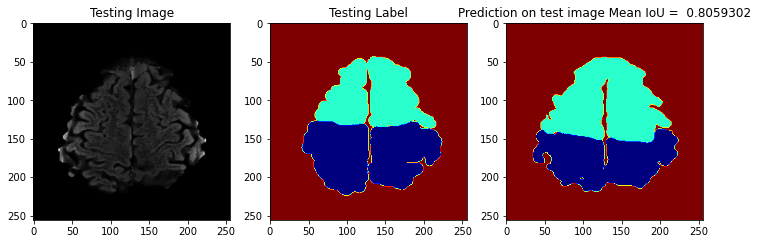

Mean IoU = 0.65375036


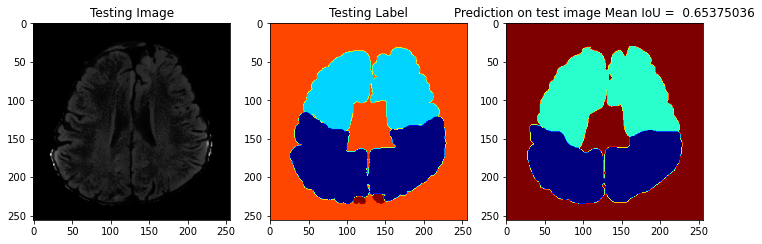

Mean IoU = 0.68012655


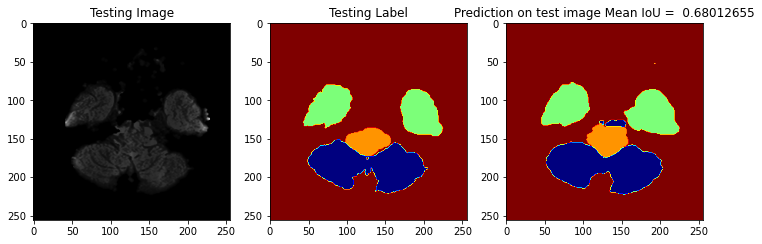

Mean IoU = 0.88881063


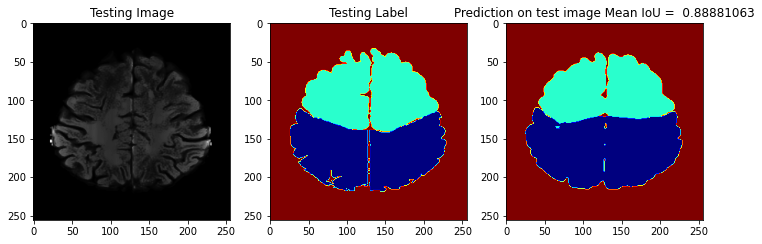

Mean IoU = 0.5499235


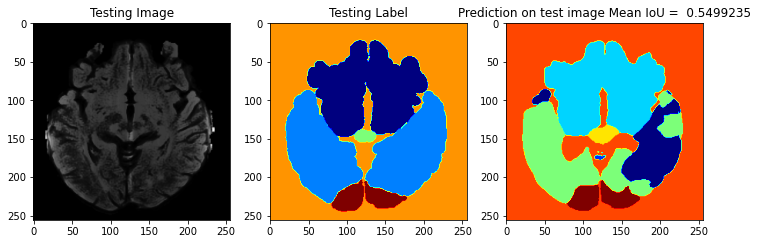

Mean IoU = 0.67426205


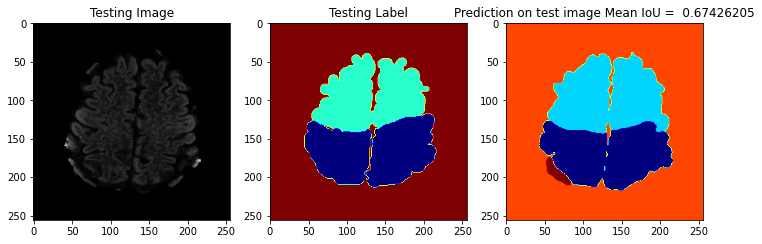

Mean IoU = 0.6060745


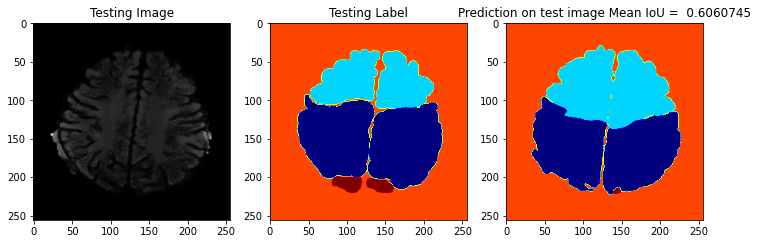

Mean IoU = 0.55073315


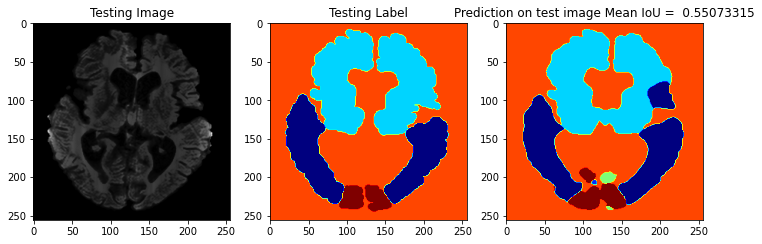

Mean IoU = 0.52399755


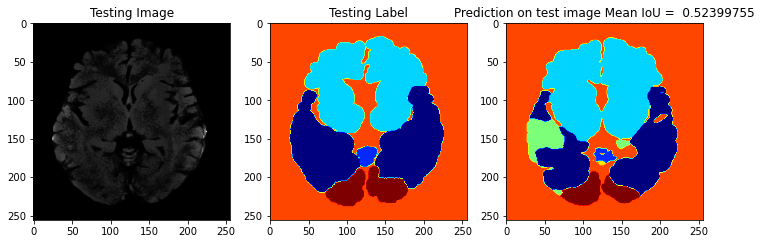

Mean IoU = 0.82991576


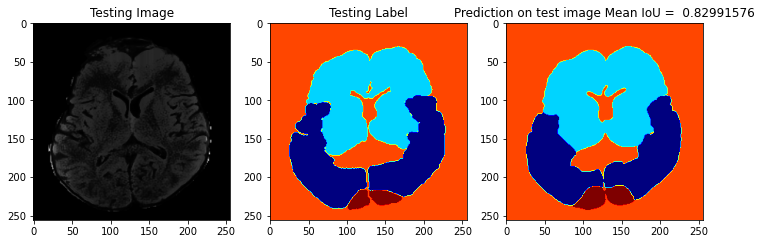

Mean IoU = 0.7721075


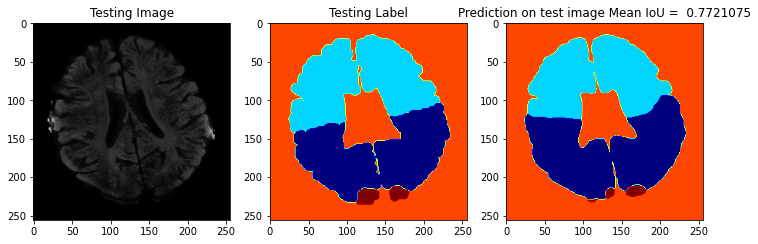

Mean IoU = 0.7131059


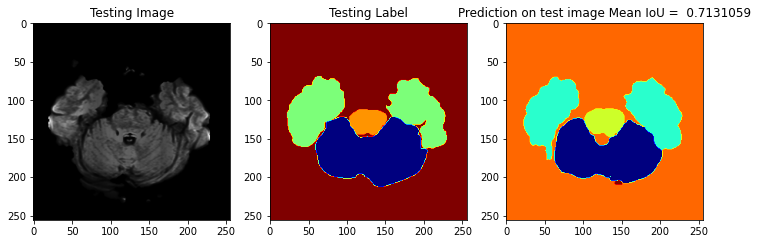

Mean IoU = 0.7757265


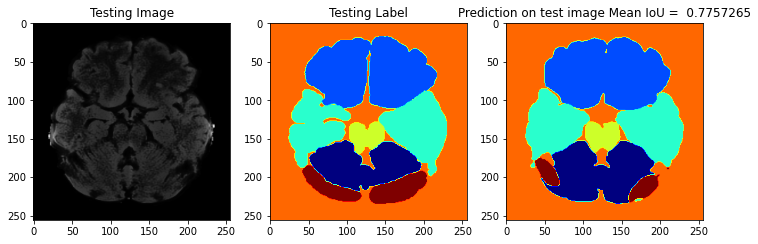

Mean IoU = 0.6078542


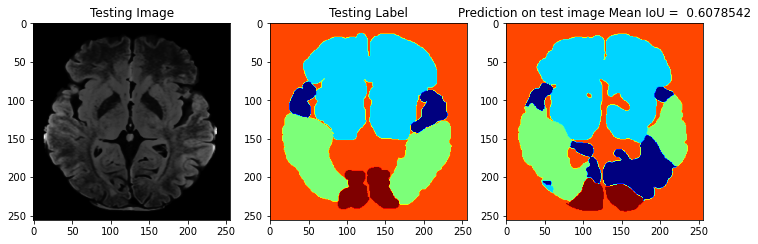

Mean IoU = 0.66115594


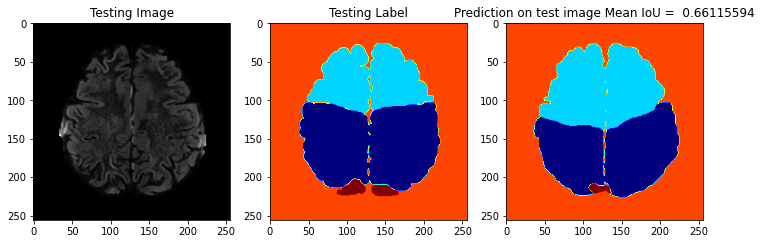

Mean IoU = 0.81532353


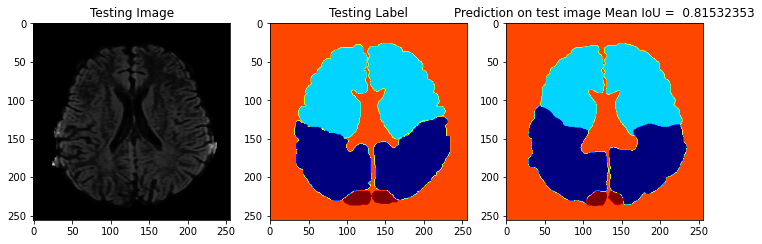

Mean IoU = 0.5270947


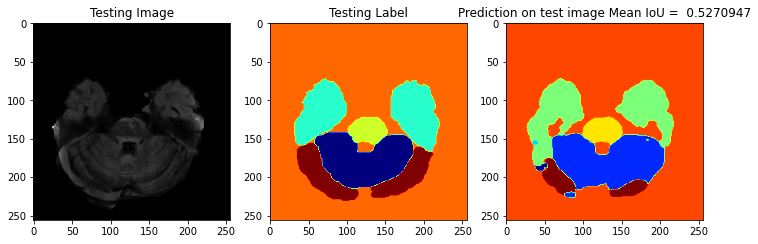

Mean IoU = 0.72659653


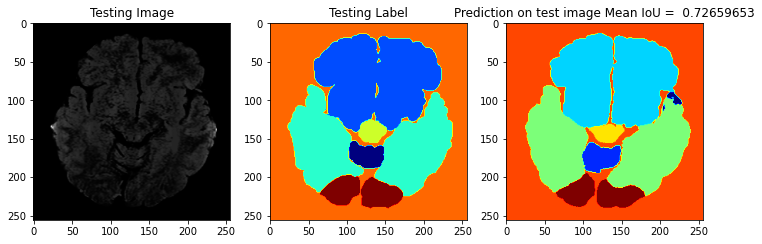

Mean IoU = 0.74004745


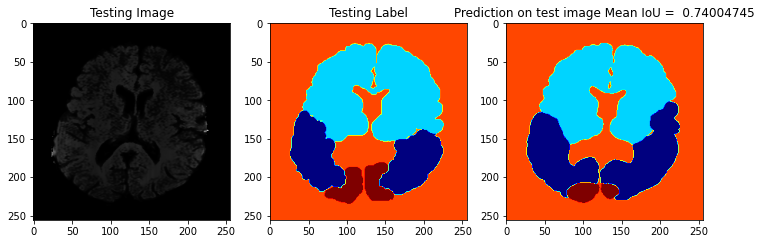

Mean IoU = 0.52245075


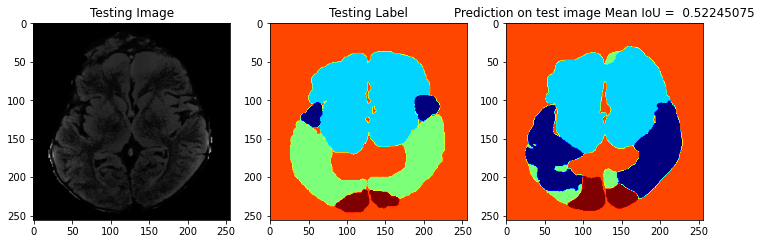

Mean IoU = 0.7376239


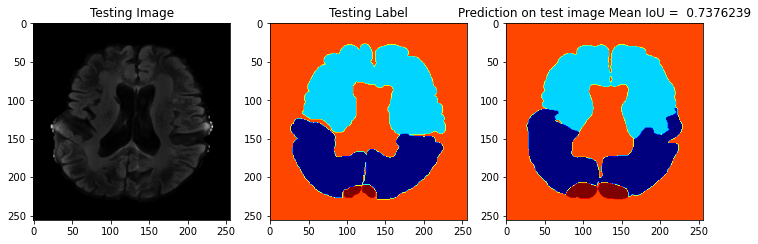

Mean IoU = 0.6765247


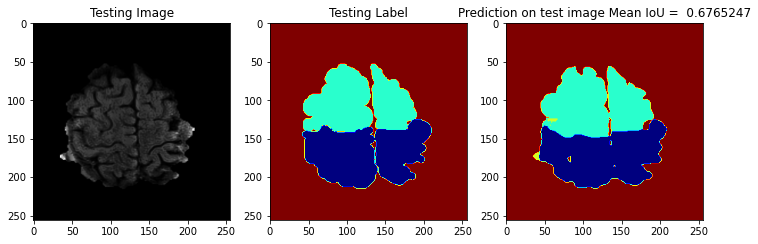

Mean IoU = 0.66054153


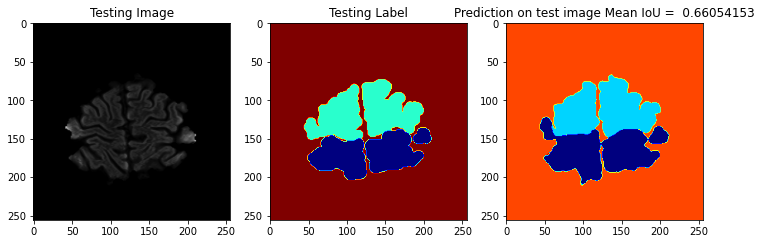

Mean IoU = 0.6841856


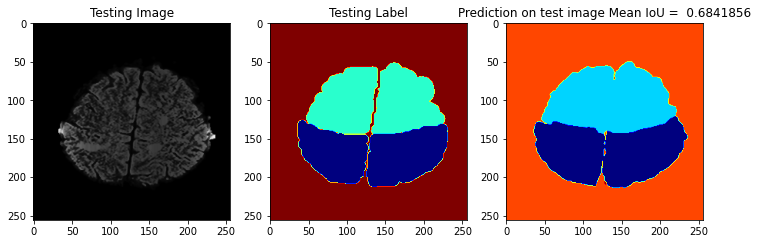

Mean IoU = 0.8681453


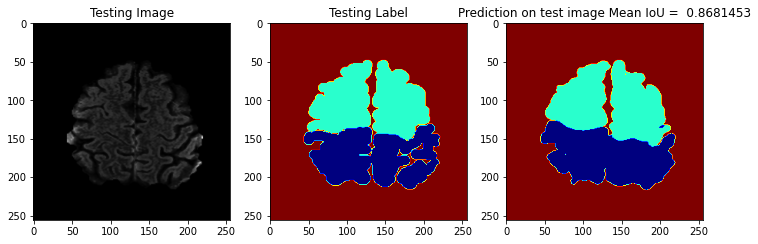

Mean IoU = 0.6564956


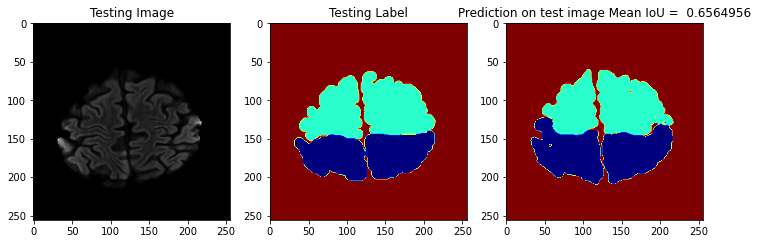

Mean IoU = 0.90158015


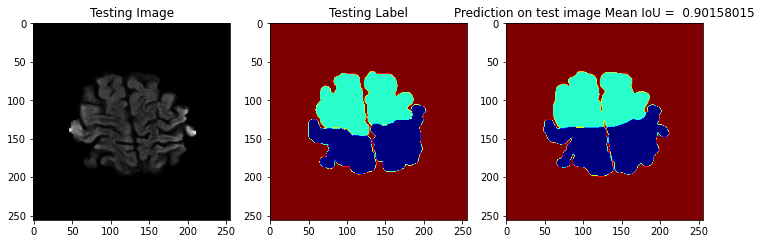

Mean IoU = 0.8307524


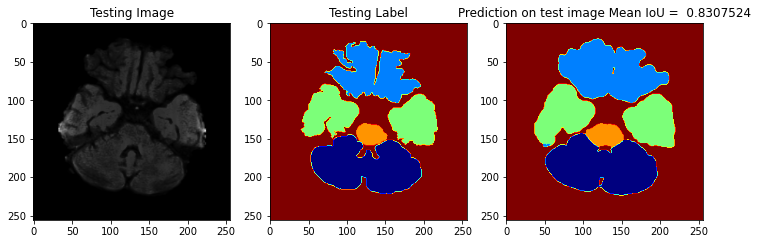

Mean IoU = 0.6090582


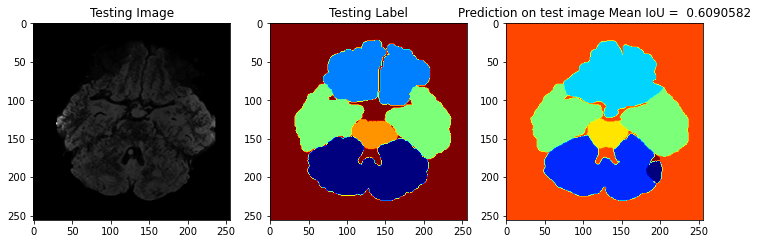

Mean IoU = 0.6864338


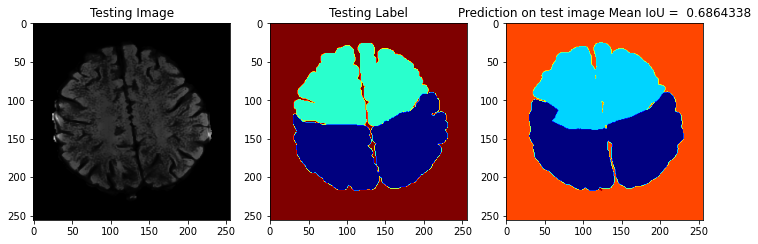

Mean IoU = 0.56914026


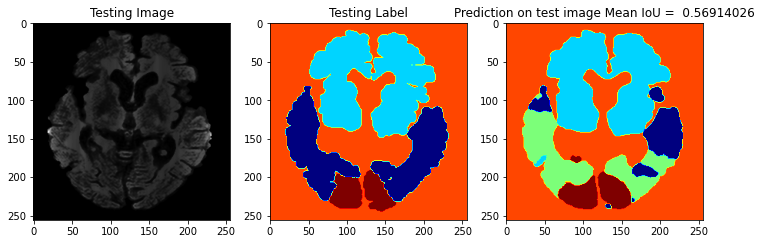

Mean IoU = 0.8241135


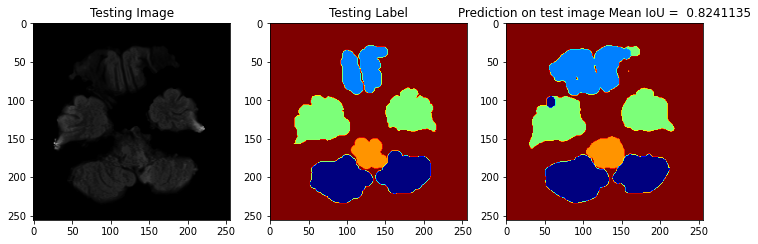

Mean IoU = 0.59183586


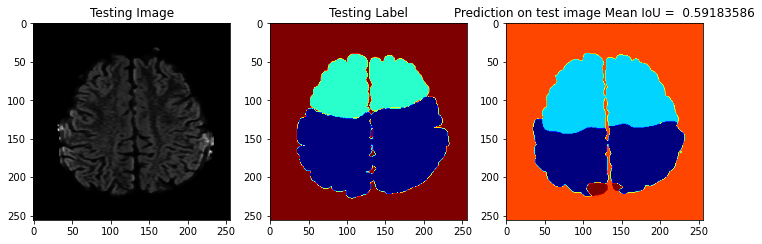

Mean IoU = 0.46273482


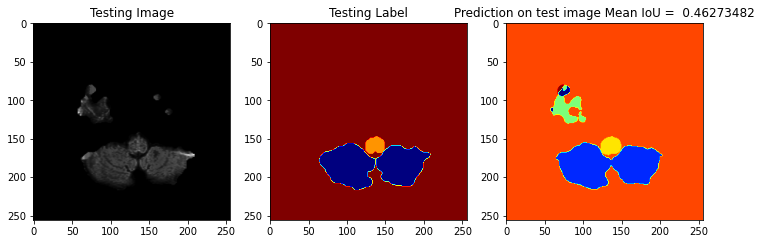

Mean IoU = 0.644538


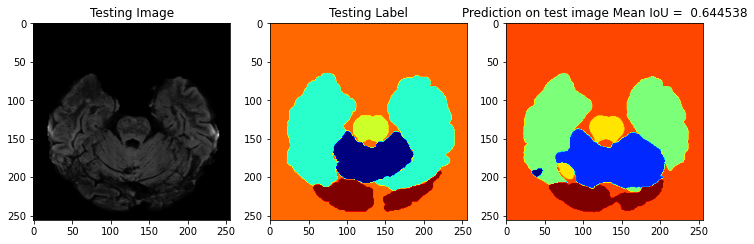

Mean IoU = 0.9176975


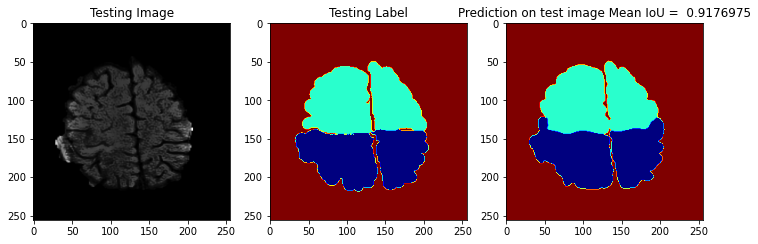

Mean IoU = 0.37567875


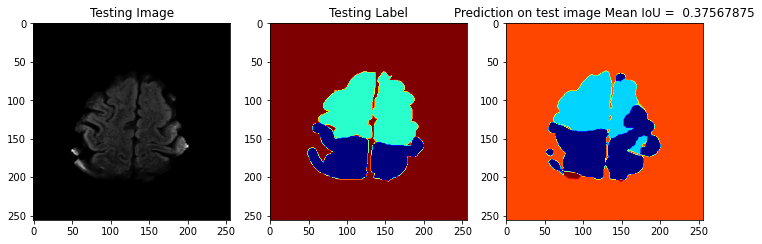

Mean IoU = 0.87011474


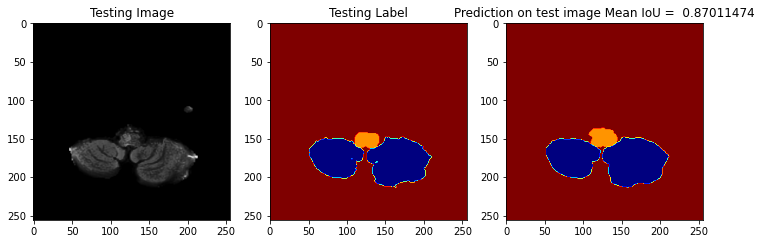

Mean IoU = 0.69991326


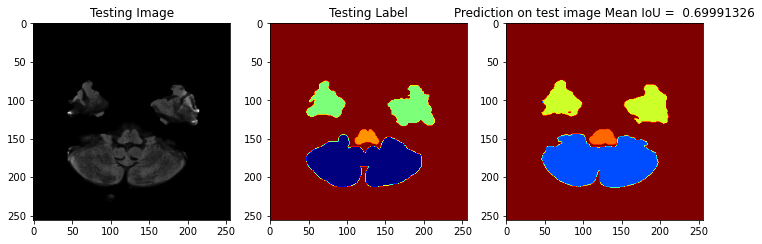

Mean IoU = 0.70488155


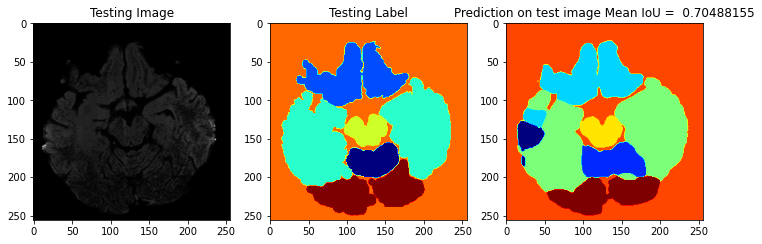

Mean IoU = 0.7243759


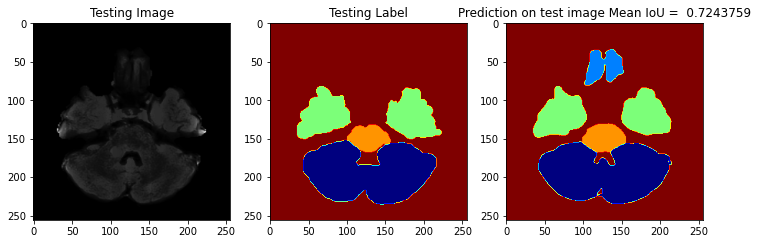

Mean IoU = 0.71222395


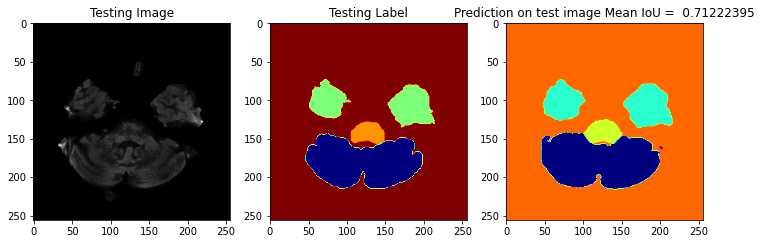

Mean IoU = 0.39884967


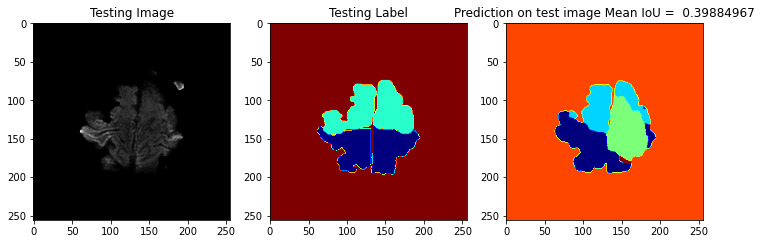

Mean IoU = 0.8220304


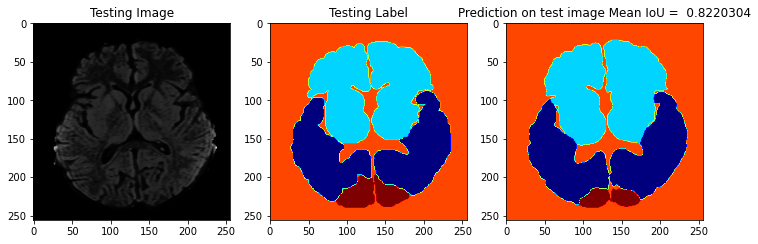

Mean IoU = 0.69829315


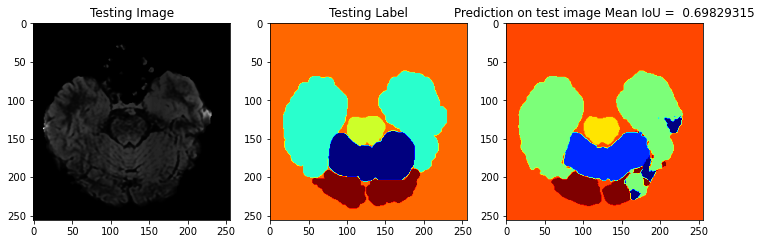

Mean IoU = 0.78892875


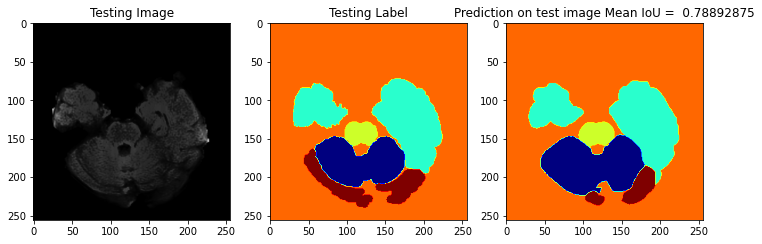

Mean IoU = 0.7234643


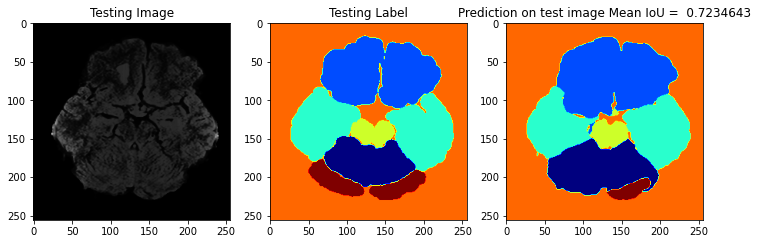

Mean IoU = 0.65037227


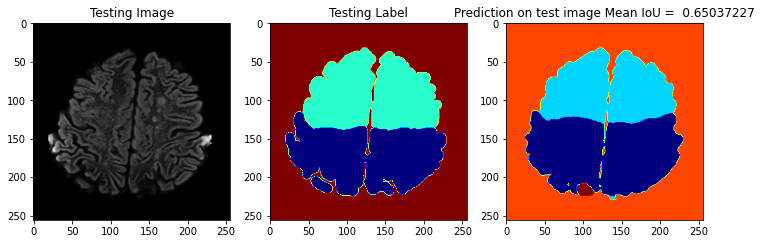

Mean IoU = 0.63557476


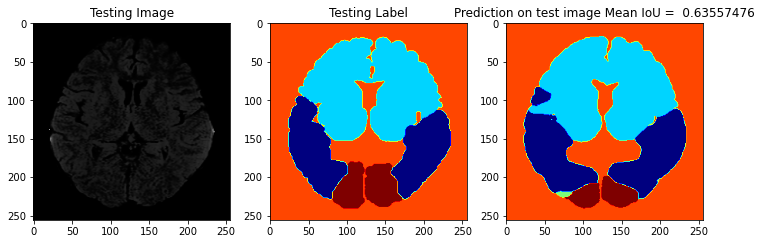

Mean IoU = 0.7743554


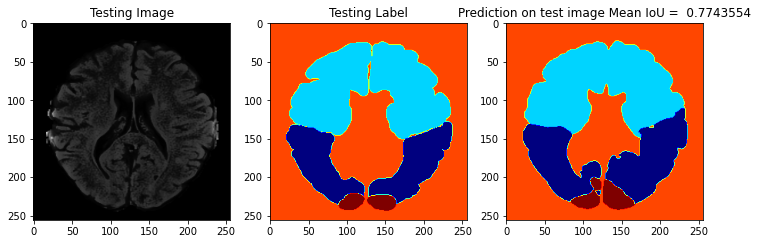

Mean IoU = 0.5625287


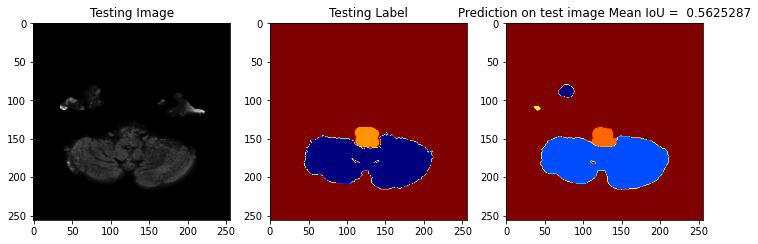

In [ ]:
#Test
##################################################
with open('./resultats.txt', 'w') as f:
    for i in range ((X_test.shape[0])):
        test_img_number = i
        test_img = X_test[test_img_number]
        ground_truth=y_test[test_img_number]
        test_img_norm=test_img[:,:,0][:,:,None]
        test_img_input=np.expand_dims(test_img_norm, 0)
        prediction = (model.predict(test_img_input))
        predicted_img=np.argmax(prediction, axis=3)[0,:,:]
        n_classes = 7
        IOU_keras = MeanIoU(num_classes=n_classes)
        IOU_keras.update_state(ground_truth, predicted_img)
        print("Mean IoU =", IOU_keras.result().numpy())
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_img[:,:,0], cmap='gray')
        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(ground_truth[:,:,0], cmap='jet')
        plt.subplot(233)
        plt.title('Prediction on test image Mean IoU =  '+str(IOU_keras.result().numpy()))
        plt.imshow(predicted_img, cmap='jet')
        plt.savefig('./testimg%d.png'%i)
        plt.show()
        f.write('./img test %d  '%i +' '+str(IOU_keras.result().numpy())+ ' \n')
